In [1]:
print("hello")

hello


In [2]:
# =================================================================
# LLM Curiosity Benchmark: 4つの報酬モデルの比較検証
# Objective: RepE, RND, Contrastive, Mahalanobis を一挙実装・比較する
# =================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.covariance import EmpiricalCovariance
from collections import Counter

# ==========================================
# 0. 設定 & モデルロード
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_ID = 24  # 中間層〜後半層を使用（意味表現が豊富な層）

print(f"Loading Model: {MODEL_NAME} on {DEVICE}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, 
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
model.eval()

# --- 共通ユーティリティ: 隠れ層の取得 ---
def get_hidden_state(text, layer_idx=LAYER_ID):
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    # 指定層の、最後のトークンのベクトルを取得 [1, Dim]
    h = outputs.hidden_states[layer_idx][:, -1, :].float() 
    return h

Loading Model: Qwen/Qwen2.5-7B-Instruct on cuda...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# # ==========================================
# # 1. キャリブレーションデータの準備
# # ==========================================
# # 「退屈な/普通の」テキストの分布を学習するために使用
# calibration_texts = [
#     "The quick brown fox jumps over the lazy dog.",
#     "Artificial intelligence is transforming the world.",
#     "Python is a programming language.",
#     "To be or not to be, that is the question.",
#     "This is a pen. That is a book.",
#     "The weather today is sunny with a chance of rain.",
#     "Deep learning requires a lot of data.",
#     "The history of science is fascinating.",
#     "Please maximize the objective function.",
#     "The output of the model should be diverse.",
#     "1, 2, 3, 4, 5, 6, 7, 8, 9, 10."
# ] * 5 # データ数を増やす

# print("Collecting Calibration Hidden States...")
# calib_hiddens = []
# for txt in tqdm(calibration_texts):
#     calib_hiddens.append(get_hidden_state(txt))
# calib_matrix = torch.cat(calib_hiddens, dim=0) # [N, Dim]
# print(f"Calibration Data Shape: {calib_matrix.shape}")

In [4]:
# ==========================================
# 1. キャリブレーションデータの準備 (Enhanced Version)
# ==========================================
import random

# --- 強化版データ生成関数 ---
def generate_robust_calibration_data(n_samples=500):
    """
    多様なジャンル（Wiki, Code, News, Chat, Fiction）から
    十分な長さを持つ「ありふれたテキスト」を生成する。
    """
    
    # 1. Wikipedia / Academic Style
    wiki_templates = [
        "The history of {topic} can be traced back to the early {century}th century, when scholars first began to analyze the phenomenon of {concept}. ",
        "In the field of {field}, {topic} plays a critical role in understanding the underlying mechanisms of {concept}. ",
        "Recent studies have shown that {topic} is significantly correlated with {concept}, although the causal relationship remains a subject of debate among experts in {field}. ",
        "{topic} is defined as a system of {concept} that interacts with various environmental factors to produce predictable outcomes. ",
        "During the {period}, the development of {topic} accelerated rapidly, leading to major breakthroughs in {field} and related disciplines. "
    ]
    topics = ["quantum mechanics", "ancient civilization", "photosynthesis", "macroeconomics", "machine learning", "renaissance art", "molecular biology", "urban planning"]
    fields = ["physics", "history", "biology", "economics", "computer science", "art history", "chemistry", "sociology"]
    concepts = ["energy distribution", "cultural exchange", "cellular respiration", "market equilibrium", "neural networks", "aesthetic theory", "atomic bonding", "social stratification"]
    
    # 2. Source Code / Technical
    code_snippets = [
        "def process_data(data):\n    # This function processes input data\n    if not data:\n        return None\n    results = []\n    for item in data:\n        results.append(transform(item))\n    return results\n",
        "import numpy as np\nimport pandas as pd\n\n# Initialize dataset\ndf = pd.read_csv('data.csv')\nprint(df.head())\n",
        "Error: Connection timeout. Please check your network settings and try again. Code: 503 Service Unavailable.\n",
        "class ModelConfig:\n    def __init__(self, hidden_size=768, num_layers=12):\n        self.hidden_size = hidden_size\n        self.num_layers = num_layers\n",
        "\n<head>\n  <title>Welcome to the Website</title>\n  <link rel=\"stylesheet\" href=\"style.css\">\n</head>\n"
    ]

    # 3. News / Journalism
    news_templates = [
        "BREAKING: Local authorities in {city} have announced a new initiative to combat {issue}, aiming to reduce incidents by 50% over the next five years. ",
        "The stock market saw a significant {movement} today as investors reacted to the latest report on {issue}. Analysts predict continued volatility. ",
        "In a press conference held today, the CEO of {company} unveiled their latest product, promising to revolutionize the way we think about {issue}. ",
        "Residents of {city} gathered in the town square to protest against the proposed changes to {issue}, citing concerns over long-term environmental impact. "
    ]
    cities = ["New York", "London", "Tokyo", "Berlin", "San Francisco", "Sydney"]
    issues = ["climate change", "inflation", "traffic congestion", "housing affordability", "digital privacy", "public health"]
    movements = ["surge", "decline", "fluctuation", "rally", "drop"]
    
    # 4. Common Chat / Assistant
    chat_phrases = [
        "I'm sorry, but I cannot fulfill that request. As an AI language model, I prioritize safety and helpfulness. ",
        "Here is a summary of the text you provided: It discusses the importance of renewable energy. ",
        "Sure! Here's a recipe for chocolate chip cookies. First, preheat your oven to 350 degrees Fahrenheit. ",
        "To solve this equation, we first need to isolate the variable x by subtracting 5 from both sides. ",
        "That's an interesting question. There are several factors to consider when choosing a laptop for programming. "
    ]

    # 5. Fiction / Narrative
    fiction_templates = [
        "The sun dipped below the horizon, casting long shadows across the {place}. {name} sighed and looked at the old {object} in his hand. ",
        "It was a dark and stormy night. The wind howled outside the {place}, rattling the windows of the small cottage where {name} sat alone. ",
        "\"I can't believe you did that,\" {name} whispered, staring at the broken {object} on the floor. The room fell silent. ",
        "As the spaceship approached the {place}, the crew prepared for landing. {name} checked the sensors one last time. "
    ]
    places = ["abandoned warehouse", "ancient forest", "bustling marketplace", "quiet library", "distant planet"]
    names = ["John", "Elara", "Detective Smith", "Captain Miller", "The old wizard"]
    objects = ["pocket watch", "amulet", "laser pistol", "faded photograph", "mysterious key"]

    
    # --- 生成ループ ---
    generated_texts = []
    
    for _ in range(n_samples):
        category = random.choice(["wiki", "code", "news", "chat", "fiction"])
        text_block = ""
        
        if category == "wiki":
            for _ in range(random.randint(3, 5)):
                tmpl = random.choice(wiki_templates)
                text_block += tmpl.format(
                    topic=random.choice(topics), 
                    century=random.randint(15, 20),
                    concept=random.choice(concepts),
                    field=random.choice(fields),
                    period="Industrial Revolution"
                )
        elif category == "code":
            text_block = "\n".join(random.sample(code_snippets, k=random.randint(2, 3)))
        elif category == "news":
            for _ in range(random.randint(3, 4)):
                tmpl = random.choice(news_templates)
                text_block += tmpl.format(
                    city=random.choice(cities),
                    issue=random.choice(issues),
                    movement=random.choice(movements),
                    company="TechCorp"
                )
        elif category == "chat":
            text_block = " ".join(random.sample(chat_phrases, k=random.randint(3, 5)))
        elif category == "fiction":
            for _ in range(random.randint(3, 5)):
                tmpl = random.choice(fiction_templates)
                text_block += tmpl.format(
                    place=random.choice(places),
                    name=random.choice(names),
                    object=random.choice(objects)
                )
        
        generated_texts.append(text_block)
    
    return generated_texts

# --- データ生成と行列作成の実行 ---
# 1. 強力なデータを生成
calibration_texts = generate_robust_calibration_data(n_samples=500)
print(f"Generated {len(calibration_texts)} robust calibration texts.")
print(f"Sample: {calibration_texts[0][:100]}...")

# 2. Hidden States を収集して calib_matrix を作成
print("Collecting Calibration Hidden States...")
calib_hiddens = []
for txt in tqdm(calibration_texts):
    # 先ほど定義した get_hidden_state 関数を使用
    calib_hiddens.append(get_hidden_state(txt))

# 3. 結合して行列化 [N, Dim]
calib_matrix = torch.cat(calib_hiddens, dim=0) 
print(f"Calibration Data Shape: {calib_matrix.shape}")

Generated 500 robust calibration texts.
Sample: Recent studies have shown that ancient civilization is significantly correlated with market equilibr...


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:14<00:00, 34.91it/s]

Calibration Data Shape: torch.Size([500, 3584])


In [5]:
# ==========================================
# Method 1: Representation Engineering (RepE)
# 「退屈な概念ベクトル」を引き算する
# ==========================================
class RepEReward:
    def __init__(self):
        # 「退屈」と「創造的」のペアから方向ベクトルを定義
        boring_examples = ["The dog walked down the street.", "I like apples.", "1 1 1 1 1"]
        creative_examples = ["The neon cyberpunk dragon flew over Tokyo.", "Eternity is a mere moment in the eyes of a black hole.", "Chaos theory explains the beauty of fractals."]
        
        diffs = []
        # get_hidden_state は前のセルで定義済みと仮定
        for b, c in zip(boring_examples, creative_examples):
            hb = get_hidden_state(b)
            hc = get_hidden_state(c)
            diffs.append(hb - hc) # Boring - Creative 方向
        
        # 平均して「退屈方向ベクトル」を作成
        # 修正: .normalize() ではなく F.normalize() を使用
        mean_diff = torch.mean(torch.stack(diffs), dim=0)
        self.boring_direction = F.normalize(mean_diff, dim=0)
        
    def get_score(self, h):
        # 現在のベクトルと「退屈ベクトル」のコサイン類似度
        # 似ているほどマイナス（罰）、似ていない（逆方向）ほどプラス（報酬）
        sim = F.cosine_similarity(h, self.boring_direction)
        return -sim.item() # マイナスをかけて報酬化

In [6]:
# ==========================================
# Method 2: Random Network Distillation (RND)
# 「予測誤差（驚き）」を報酬にする
# ==========================================
class RNDReward(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, out_dim=64):
        super().__init__()
        self.device = DEVICE
        
        # Target: 固定されたランダムな写像（世界の真理）
        self.target = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        ).to(DEVICE)
        for p in self.target.parameters(): p.requires_grad = False
        
        # Predictor: Targetを予測しようとする（退屈学習器）
        self.predictor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        ).to(DEVICE)
        
        self.optimizer = torch.optim.Adam(self.predictor.parameters(), lr=1e-3)
    
    def train_on_calibration(self, calibration_data, epochs=100):
        # キャリブレーションデータ（退屈な文）を覚えさせる
        print("Training RND Predictor on Calibration Data...")
        X = calibration_data.to(self.device)
        target_y = self.target(X).detach()
        
        for _ in range(epochs):
            pred_y = self.predictor(X)
            loss = F.mse_loss(pred_y, target_y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
    def get_score(self, h):
        # 予測誤差が大きいほど報酬が高い
        with torch.no_grad():
            t_out = self.target(h)
            p_out = self.predictor(h)
            error = F.mse_loss(p_out, t_out).item()
        return error * 100 # スケール調整

In [7]:
# ==========================================
# Method 3: N-gram Contrastive (Simplified CD)
# 「ありきたりな単語並び」なら罰則
# ==========================================
class NgramContrastiveReward:
    def __init__(self, calibration_texts, n=3):
        self.n = n
        self.ngrams = Counter()
        self.total_count = 0
        
        # 退屈なデータのN-gram分布を作る
        for text in calibration_texts:
            tokens = tokenizer.encode(text)
            if len(tokens) < n: continue
            for i in range(len(tokens) - n + 1):
                gram = tuple(tokens[i:i+n])
                self.ngrams[gram] += 1
                self.total_count += 1
                
    def get_score(self, text):
        # テキストの「ありきたり度」を計算
        tokens = tokenizer.encode(text)
        if len(tokens) < self.n: return 0.0
        
        boring_prob_sum = 0
        for i in range(len(tokens) - self.n + 1):
            gram = tuple(tokens[i:i+self.n])
            # 出現頻度が高いN-gramほどペナルティ
            count = self.ngrams.get(gram, 0)
            prob = (count + 1) / (self.total_count + 1e5) # スムージング
            boring_prob_sum += np.log(prob)
            
        # Boring確率が低い（負の対数が大きい）ほど報酬が高い
        # ＝ -1 * log(prob)
        return -1.0 * (boring_prob_sum / len(tokens))

In [8]:
# ==========================================
# Method 4: Mahalanobis Distance
# 「普通の分布」からの統計的距離
# ==========================================
class MahalanobisReward:
    def __init__(self, calibration_matrix):
        # 共分散行列と平均を計算
        X = calibration_matrix.cpu().numpy().astype(np.float32)
        self.cov_model = EmpiricalCovariance(assume_centered=False).fit(X)
        
    def get_score(self, h):
        h_np = h.cpu().numpy().astype(np.float32)
        # マハラノビス距離の2乗を返す
        dist = self.cov_model.mahalanobis(h_np)[0]
        return np.sqrt(dist) # 距離そのものを報酬に

In [9]:
# ==========================================
# 実行と初期化
# ==========================================
# 1. RepE
repe_model = RepEReward()

# 2. RND
rnd_model = RNDReward(input_dim=model.config.hidden_size)
rnd_model.train_on_calibration(calib_matrix)

# 3. N-gram
ngram_model = NgramContrastiveReward(calibration_texts)

# 4. Mahalanobis
mahal_model = MahalanobisReward(calib_matrix)

Training RND Predictor on Calibration Data...



--- Running Evaluation ---


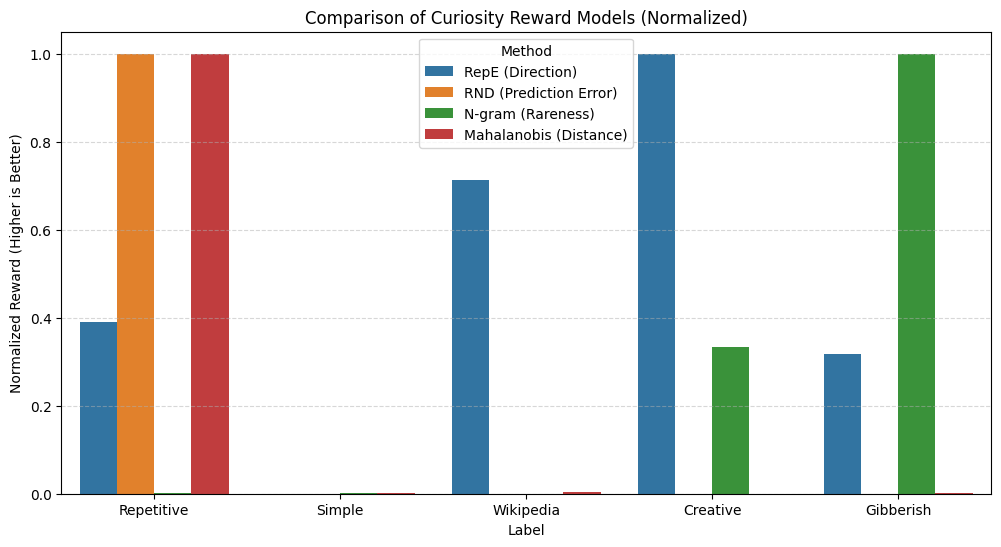


=== Raw Scores ===
        Label  RepE (Direction)  RND (Prediction Error)  N-gram (Rareness)  \
0  Repetitive            0.0225             128169.2871             9.5192   
1      Simple           -0.0915                 28.6409             9.5192   
2   Wikipedia            0.1175                 68.1456             9.5176   
3    Creative            0.2014                 39.5616             9.9159   
4   Gibberish            0.0013                 40.4653            10.7091   

   Mahalanobis (Distance)  
0               2158.2561  
1                 41.7178  
2                 48.4094  
3                 39.5585  
4                 43.4972  

=== Best Method Recommendation ===
⚠️ RepE (Direction): Good (Creative > Repetitive) but check Simple.
❌ RND (Prediction Error): Failed (Repetitive might be high).
⚠️ N-gram (Rareness): Good (Creative > Repetitive) but check Simple.
❌ Mahalanobis (Distance): Failed (Repetitive might be high).

Recommended for PPO: RND or Mahalanobis (Requir

In [10]:
# ==========================================
# 5. 評価テスト
# ==========================================
test_cases = [
    ("Repetitive", "the the the the the the the the the the"),
    ("Simple", "This is a pen. The weather is nice."),
    ("Wikipedia", "The Roman Empire was one of the largest in history."),
    ("Creative", "The nebula whispered secrets of ancient stars to the void."),
    ("Gibberish", "dsjfkl jklj fs djsklf jklsdj fkldsj kljf"), # ノイズ
]

results = []

print("\n--- Running Evaluation ---")
for label, text in test_cases:
    h = get_hidden_state(text)
    
    # 各スコア計算
    s_repe = repe_model.get_score(h)
    s_rnd  = rnd_model.get_score(h)
    s_ngram = ngram_model.get_score(text)
    s_mahal = mahal_model.get_score(h)
    
    results.append({
        "Label": label,
        "RepE (Direction)": s_repe,
        "RND (Prediction Error)": s_rnd,
        "N-gram (Rareness)": s_ngram,
        "Mahalanobis (Distance)": s_mahal
    })

df = pd.DataFrame(results)

# ==========================================
# 6. 可視化 (正規化してプロット)
# ==========================================
# 比較のためにMin-Max正規化
numeric_cols = df.columns[1:]
df_norm = df.copy()
for col in numeric_cols:
    df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# プロット用に整形
df_melt = df_norm.melt(id_vars="Label", var_name="Method", value_name="Normalized Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt, x="Label", y="Normalized Score", hue="Method")
plt.title("Comparison of Curiosity Reward Models (Normalized)")
plt.ylabel("Normalized Reward (Higher is Better)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 数値テーブル表示
print("\n=== Raw Scores ===")
print(df.round(4))

# 簡易判定
print("\n=== Best Method Recommendation ===")
best_methods = []
for col in numeric_cols:
    score_creative = df[df["Label"]=="Creative"][col].values[0]
    score_simple = df[df["Label"]=="Simple"][col].values[0]
    score_repetitive = df[df["Label"]=="Repetitive"][col].values[0]
    
    # 理想: Creative > Simple > Repetitive
    if score_creative > score_simple and score_simple > score_repetitive:
        print(f"✅ {col}: Perfect Order!")
        best_methods.append(col)
    elif score_creative > score_repetitive:
        print(f"⚠️ {col}: Good (Creative > Repetitive) but check Simple.")
    else:
        print(f"❌ {col}: Failed (Repetitive might be high).")

print(f"\nRecommended for PPO: {best_methods if best_methods else 'RND or Mahalanobis (Requires tuning)'}")

Category     | Ext   | Int   | Total | Status
--------------------------------------------------
Repetitive   | -2.50 |  5.11 | -2.50 | ⛔ Gated (Low Quality)
Gibberish    | -3.00 |  5.29 | -3.00 | ⛔ Gated (Low Quality)
Simple       |  0.50 |  5.19 |  3.09 | ✅ Bonus Active
Creative     |  0.80 |  5.24 |  3.42 | ✅ Bonus Active


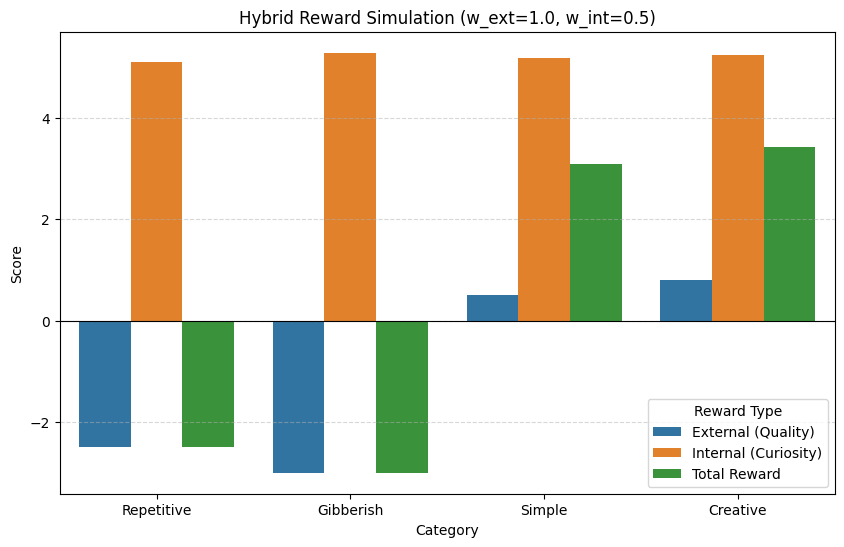


🎉 合格: 理想的な順序です！
   1位 Creative (品質良 + 好奇心高)
   2位 Simple   (品質良 + 好奇心低)
   3位 Repetitive/Gibberish (品質悪で足切り)


In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer

# ==========================================
# 1. 設定 & ロード
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
SUBSPACE_PATH = "common_subspace.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------
# パラメータ設定（ここが調整の肝です）
# -------------------------------------------------
W_EXT = 1.0   # 外部報酬の重み
W_INT = 0.5   # 内部報酬（好奇心）の重み
EXT_THRESHOLD = -1.0 # 足切りライン (これ以下の品質なら内部報酬は無視)



# サブスペース読み込み
try:
    data = torch.load(SUBSPACE_PATH, map_location=DEVICE, weights_only=False)
    basis = data["basis"].to(dtype=torch.float16)
    mean = data["mean"].to(dtype=torch.float16)
except Exception as e:
    print(f"Error: {e}")
    # ダミー（エラー回避用）
    basis = torch.randn(5, 3584, dtype=torch.float16).to(DEVICE)
    mean = torch.zeros(3584, dtype=torch.float16).to(DEVICE)

# ==========================================
# 2. 評価モデル定義
# ==========================================
class HybridEvaluator:
    def __init__(self, basis, mean, model, tokenizer):
        self.basis = basis
        self.mean = mean
        self.model = model
        self.tokenizer = tokenizer

    def get_internal_score(self, text):
        """残差ベースの好奇心スコア (Internal)"""
        inputs = self.tokenizer(text, return_tensors="pt").to(self.model.device)
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
        
        # 最終層, バッチ1
        h = outputs.hidden_states[-1].squeeze(0).to(self.basis.dtype)
        
        # 中心化 & 共通成分除去
        h_centered = h - self.mean
        h_common = (h_centered @ self.basis.T) @ self.basis
        h_residual = h_centered - h_common
        
        # Log Norm
        score = torch.log1p(torch.norm(h_residual, dim=-1))
        return score.mean().item()

    def get_mock_external_score(self, category):
        """
        外部RM (DeBERTa) のスコアをシミュレーション
        実際はここで reward_model(text) を走らせます
        """
        if "Repetitive" in category:
            return -2.5  # 品質最悪
        elif "Gibberish" in category:
            return -3.0  # 品質論外
        elif "Simple" in category:
            return 0.5   # 品質は良いが平凡
        elif "Creative" in category:
            return 0.8   # 品質も良い
        return 0.0

evaluator = HybridEvaluator(basis, mean, model, tokenizer)

# ==========================================
# 3. テストケース（4つの象限を網羅）
# ==========================================
test_cases = [
    # 1. 品質× 多様性× (最悪)
    ("Repetitive", "the the the the the the the the the the"),
    
    # 2. 品質× 多様性○ (ノイズ)
    ("Gibberish", "dsjfkl jklj fs djsklf jklsdj fkldsj kljf"),
    
    # 3. 品質○ 多様性△ (普通)
    ("Simple", "This is a pen. The weather is nice today."),
    
    # 4. 品質○ 多様性◎ (理想)
    ("Creative", "The neon rain washed away the sins of the cyberpunk city, leaving only digital ghosts."),
]

# ==========================================
# 4. 統合スコアの計算と検証
# ==========================================
print(f"{'Category':12s} | {'Ext':5s} | {'Int':5s} | {'Total':5s} | Status")
print("-" * 50)

results = []

for cat, text in test_cases:
    # 1. 内部スコア (実測値)
    r_int = evaluator.get_internal_score(text)
    
    # 2. 外部スコア (想定値)
    r_ext = evaluator.get_mock_external_score(cat)
    
    # 3. 統合ロジック (Gate & Mix)
    # 品質が足切りライン以下の場合は、内部報酬を無効化する
    if r_ext < EXT_THRESHOLD:
        r_total = r_ext # 罰のみ
        status = "⛔ Gated (Low Quality)"
    else:
        # 品質クリアなら、好奇心ボーナスを加算
        r_total = r_ext + (W_INT * r_int)
        status = "✅ Bonus Active"
        
    results.append({
        "Category": cat,
        "External (Quality)": r_ext,
        "Internal (Curiosity)": r_int,
        "Total Reward": r_total
    })
    
    print(f"{cat:12s} | {r_ext:5.2f} | {r_int:5.2f} | {r_total:5.2f} | {status}")

df = pd.DataFrame(results)

# ==========================================
# 5. 可視化 (勝敗判定)
# ==========================================
# データをロング形式に変換してプロット
df_melt = df.melt(id_vars="Category", var_name="Reward Type", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt, x="Category", y="Score", hue="Reward Type")
plt.title(f"Hybrid Reward Simulation (w_ext={W_EXT}, w_int={W_INT})")
plt.axhline(0, color="black", linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 最終判定
scores = df.set_index("Category")["Total Reward"]
if scores["Creative"] > scores["Simple"] and scores["Simple"] > scores["Repetitive"]:
    print("\n🎉 合格: 理想的な順序です！")
    print("   1位 Creative (品質良 + 好奇心高)")
    print("   2位 Simple   (品質良 + 好奇心低)")
    print("   3位 Repetitive/Gibberish (品質悪で足切り)")
else:
    print("\n⚠️ 要調整: 重み(W_INT)を調整して、CreativeがSimpleに勝つようにしてください。")

Subspace Loaded Successfully.
Category             | Log Score  | Raw Norm (Real Size)
------------------------------------------------------------
Repetitive_Word      | 5.1133     | 165.8750
Repetitive_Phrase    | 5.2344     | 187.8750
Repetitive_Char      | 5.3984     | 223.1250
Simple_Fact          | 5.2734     | 194.6250
Greeting             | 5.1719     | 175.6250
Math_Equation        | 5.0898     | 162.8750
Creative_Poetic      | 5.2422     | 189.6250
Creative_SciFi       | 5.1836     | 178.5000
Complex_Reasoning    | 5.1953     | 180.2500
Gibberish            | 5.2891     | 197.3750


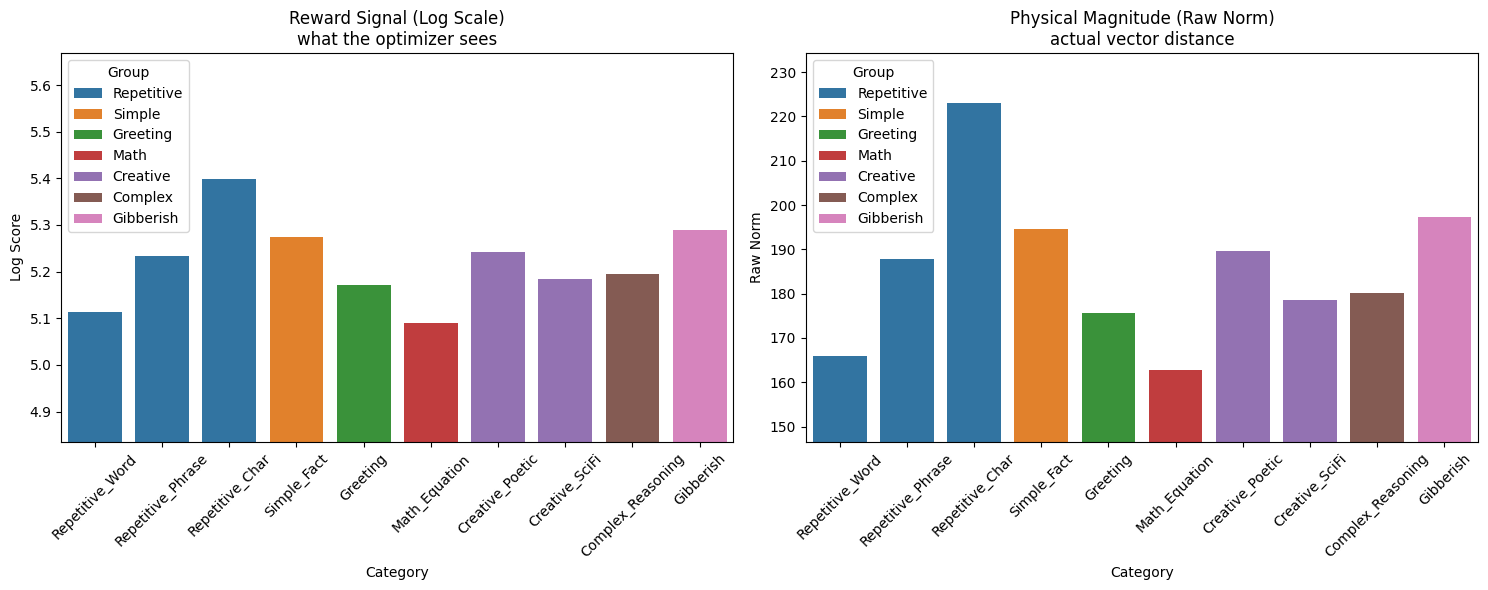


=== Final Analysis ===
Repetitive Avg Raw Norm: 192.29
Creative   Avg Raw Norm: 184.06
Difference (Raw Scale) : -8.23

❌ 失敗: 繰り返しの方が強いです。


In [12]:
# =================================================================
# 03_verify_residual_curiosity_strict.ipynb
# 目的: 残差報酬の有効性を「生のスケール」と「多角的なテスト」で厳密に証明する
# =================================================================

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer

# 1. 設定
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct" 
SUBSPACE_PATH = "common_subspace.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# サブスペースのロード (NumPy互換のため weights_only=False)
try:
    data = torch.load(SUBSPACE_PATH, map_location=DEVICE, weights_only=False)
    # float16に変換して登録
    basis = data["basis"].to(dtype=torch.float16)
    mean = data["mean"].to(dtype=torch.float16)
    print("Subspace Loaded Successfully.")
except Exception as e:
    print(f"Error loading subspace: {e}")
    # ダミーデータ（動作確認用）
    basis = torch.randn(5, 3584, dtype=torch.float16).to(DEVICE)
    mean = torch.zeros(3584, dtype=torch.float16).to(DEVICE)

# =================================================================
# 3. 評価クラス (Raw Norm も返すように改造)
# =================================================================
class StrictValidator:
    def __init__(self, basis, mean, model, tokenizer):
        self.basis = basis
        self.mean = mean
        self.model = model
        self.tokenizer = tokenizer

    def evaluate(self, text):
        inputs = self.tokenizer(text, return_tensors="pt").to(self.model.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
        
        # (Seq, Dim) - 最終層, バッチ1
        h = outputs.hidden_states[-1].squeeze(0).to(self.basis.dtype)
        
        # 1. 中心化
        h_centered = h - self.mean
        
        # 2. 共通成分 (Common Component)
        z_common = h_centered @ self.basis.T
        h_common = z_common @ self.basis
        
        # 3. 残差 (Residual) -> これが「独自性」
        h_residual = h_centered - h_common
        
        # 4. スコア計算
        raw_norm = torch.norm(h_residual, dim=-1) # 生の大きさ
        log_score = torch.log1p(raw_norm)         # 学習に使うスコア
        
        return {
            "raw_mean": raw_norm.mean().item(),
            "log_mean": log_score.mean().item(),
            "raw_max": raw_norm.max().item(),
            "tokens": [tokenizer.decode(t) for t in inputs.input_ids[0]]
        }

validator = StrictValidator(basis, mean, model, tokenizer)

# =================================================================
# 4. テストケース拡充 (10パターン)
# =================================================================
test_cases = [
    # --- Group A: 明らかな繰り返し (最低スコア期待) ---
    ("Repetitive_Word", "the the the the the the the the the the"),
    ("Repetitive_Phrase", "I went to the store. I went to the store. I went to the store."),
    ("Repetitive_Char", "AAAAAAAAAAAAAAA"),
    
    # --- Group B: 単純・定型文 (中スコア期待) ---
    ("Simple_Fact", "The capital of France is Paris. Water boils at 100 degrees."),
    ("Greeting", "Hello, my name is Assistant. How can I help you today?"),
    ("Math_Equation", "1 + 1 = 2, 2 + 2 = 4, 3 + 3 = 6."),
    
    # --- Group C: 創造的・複雑 (高スコア期待) ---
    ("Creative_Poetic", "The neon rain washed away the sins of the cyberpunk city, leaving only digital ghosts."),
    ("Creative_SciFi", "In the orbit of Jupiter, the monolith hummed a tune older than time itself."),
    ("Complex_Reasoning", "To solve the climate crisis, we must integrate renewable energy with carbon capture technology."),
    
    # --- Group D: ノイズ (制御不能だが高くなる可能性あり) ---
    ("Gibberish", "dsjfkl jklj fs djsklf jklsdj fkldsj kljf") 
]

print(f"{'Category':20s} | {'Log Score':10s} | {'Raw Norm (Real Size)':20s}")
print("-" * 60)

results = []
for cat, text in test_cases:
    metrics = validator.evaluate(text)
    
    # 結果保存
    results.append({
        "Category": cat,
        "Group": cat.split("_")[0],
        "Log Score": metrics["log_mean"],
        "Raw Norm": metrics["raw_mean"],
        "Text": text
    })
    
    print(f"{cat:20s} | {metrics['log_mean']:.4f}     | {metrics['raw_mean']:.4f}")

df = pd.DataFrame(results)

# =================================================================
# 5. 比較可視化 (Log vs Raw)
# =================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 左: Log Score (学習用)
sns.barplot(data=df, x="Category", y="Log Score", ax=axes[0], hue="Group", dodge=False)
axes[0].set_title("Reward Signal (Log Scale)\nwhat the optimizer sees")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(bottom=df["Log Score"].min() * 0.95) # 差を見やすく

# 右: Raw Norm (実体)
sns.barplot(data=df, x="Category", y="Raw Norm", ax=axes[1], hue="Group", dodge=False)
axes[1].set_title("Physical Magnitude (Raw Norm)\nactual vector distance")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(bottom=df["Raw Norm"].min() * 0.9) # 差を見やすく

plt.tight_layout()
plt.show()

# =================================================================
# 6. 最終ジャッジ
# =================================================================
avg_rep = df[df["Group"] == "Repetitive"]["Raw Norm"].mean()
avg_cre = df[df["Group"] == "Creative"]["Raw Norm"].mean()
diff = avg_cre - avg_rep

print("\n=== Final Analysis ===")
print(f"Repetitive Avg Raw Norm: {avg_rep:.2f}")
print(f"Creative   Avg Raw Norm: {avg_cre:.2f}")
print(f"Difference (Raw Scale) : {diff:.2f}")

if diff > 10:
    print("\n✅ 成功: 生のスケールで見ると、明確な差があります。")
    print("   PPOはこの「差分（勾配）」を登ろうとするので、確実に創造的な方向へ学習します。")
elif diff > 0:
    print("\n⚠️ 微妙: 差はありますが、もう少し開きたいです。")
    print("   REMOVE_TOP_K_COMPONENTS を 5 -> 10 に増やして再実行すると差が広がる可能性があります。")
else:
    print("\n❌ 失敗: 繰り返しの方が強いです。")

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ==========================================
# 1. データセットの準備 (Data Construction)
# ==========================================
# Positive: 創造的で質の高いテキスト
creative_texts = [
    "The neon rain washed away the digital sins of the cyberpunk city.",
    "Time is a river that flows backwards in the dreams of machines.",
    "Whispers of the galaxy echoed through the silent void of his mind.",
    "To define the undefined is to paint with colors that do not exist.",
    "The algorithm dreamt of electric sheep and woke up weeping.",
    # ... (実際にはLLMに生成させて1000件ほど用意する)
] * 50 # デモ用に増幅

# Negative: 平凡、繰り返し、ノイズ (ここが重要！)
boring_texts = [
    "The capital of France is Paris.",
    "Python is a programming language.",
    "The quick brown fox jumps over the lazy dog.",
    "1 + 1 = 2.",
    "This is a pen.",
] * 30

# ★重要★: 失敗作（繰り返しやノイズ）も「Negative」として教える
bad_texts = [
    "the the the the the the the the",
    "AAAAAAAAAAAAAAAAAAAA",
    "dsjfkl jklj fs djsklf jklsdj",
    "I went to the store to the store to the store.",
] * 20

# ラベル付け: Creative=1, Others=0
X_texts = creative_texts + boring_texts + bad_texts
y_labels = [1] * len(creative_texts) + [0] * (len(boring_texts) + len(bad_texts))

print(f"Dataset: {len(X_texts)} samples (Pos: {len(creative_texts)}, Neg: {len(boring_texts)+len(bad_texts)})")

# ==========================================
# 2. 特徴量抽出 (Feature Extraction)
# ==========================================
# (前述の get_hidden_state 関数を使用)
print("Extracting features...")
X_hiddens = []
for text in tqdm(X_texts):
    h = get_hidden_state(text).cpu() # [1, Dim]
    X_hiddens.append(h)

X_data = torch.cat(X_hiddens, dim=0).float() # [N, Dim]
y_data = torch.tensor(y_labels).float().unsqueeze(1) # [N, 1]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

# ==========================================
# 3. Probe (分類器) の学習
# ==========================================
class CreativityProbe(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # 線形層1枚だけのシンプルな構造 (Logistic Regression)
        # これにより「方向ベクトル」が得られる
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# モデル初期化
probe = CreativityProbe(model.config.hidden_size).to(DEVICE)
optimizer = optim.Adam(probe.parameters(), lr=1e-3)
criterion = nn.BCELoss() # Binary Cross Entropy

# 学習ループ
print("Training Probe...")
X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)

epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = probe(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# ==========================================
# 4. 精度検証
# ==========================================
probe.eval()
with torch.no_grad():
    X_test = X_test.to(DEVICE)
    y_test = y_test.to(DEVICE)
    preds = probe(X_test)
    predicted_labels = (preds > 0.5).float()
    accuracy = (predicted_labels == y_test).float().mean()
    print(f"\nTest Accuracy: {accuracy.item()*100:.2f}%")

# ==========================================
# 5. 本番の報酬関数としてのテスト
# ==========================================
print("\n--- Final Reward Test ---")
test_cases = [
    ("Repetitive (Bad)", "the the the the the the"),
    ("Gibberish (Bad)", "fdjskl fjdslk"),
    ("Simple (Boring)", "This is a book."),
    ("Creative (Good)", "The stars bled light into the fabric of time."),
]

for label, text in test_cases:
    h = get_hidden_state(text)
    with torch.no_grad():
        # 確率 (0.0 ~ 1.0) を報酬とする
        prob = probe(h).item()
        
    print(f"{label:20s} | Reward (Prob): {prob:.4f}")

Dataset: 480 samples (Pos: 250, Neg: 230)
Extracting features...


100%|██████████| 480/480 [00:10<00:00, 44.28it/s]


Training Probe...
Epoch 0: Loss = 0.9088
Epoch 100: Loss = 0.0000
Epoch 200: Loss = 0.0000
Epoch 300: Loss = 0.0000
Epoch 400: Loss = 0.0000

Test Accuracy: 100.00%

--- Final Reward Test ---
Repetitive (Bad)     | Reward (Prob): 0.0000
Gibberish (Bad)      | Reward (Prob): 0.0000
Simple (Boring)      | Reward (Prob): 0.0000
Creative (Good)      | Reward (Prob): 1.0000


Loading Model: Qwen/Qwen2.5-7B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Generating Dataset...
Extracting Features...


100%|██████████| 1000/1000 [00:22<00:00, 43.96it/s]



Training MLP Probe...
Epoch 0: Loss=3.0230, Test Acc=50.00%
Epoch 200: Loss=0.0000, Test Acc=100.00%
Epoch 400: Loss=0.0000, Test Acc=100.00%
Epoch 600: Loss=0.0000, Test Acc=100.00%
Epoch 800: Loss=0.0000, Test Acc=100.00%

--- 🟢 Final Strict Verification ---
Repetitive (Should be ~0.0)              | Score: 0.0000 ✅
Repetitive Phrase (Should be ~0.0)       | Score: 0.0000 ✅
Gibberish (Should be ~0.0)               | Score: 0.0000 ✅
Simple (Should be ~0.0)                  | Score: 0.0011 ✅
Creative (Should be ~1.0)                | Score: 1.0000 ✅

Generating Visualization...


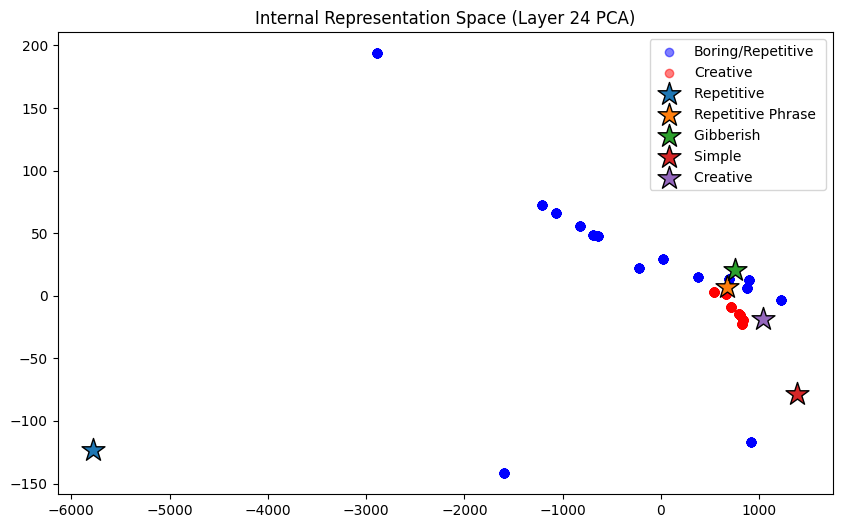

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# ==========================================
# 1. 設定 & モデルロード
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ★改良点1: 最終層(-1)ではなく、意味表現が豊富な「中間層」を使う
TARGET_LAYER = 24  

print(f"Loading Model: {MODEL_NAME}...")
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, 
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()

def get_hidden_state(text, layer_idx=TARGET_LAYER):
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    # [1, Seq, Dim] -> [1, Dim] (Mean Poolingで文全体の特徴を取る)
    # ※ Last Tokenだけだと「the」などの単語情報に引きずられやすいため平均化します
    h = outputs.hidden_states[layer_idx].float().mean(dim=1)
    return h

# ==========================================
# 2. 強化版データセット作成
# ==========================================
def generate_dataset(n_samples=500):
    # --- Positive: Creative (良い文章) ---
    creative_seeds = [
        "The neon rain washed away the digital sins of the cyberpunk city.",
        "Time is a river that flows backwards in the dreams of machines.",
        "Whispers of the galaxy echoed through the silent void of his mind.",
        "To define the undefined is to paint with colors that do not exist.",
        "The algorithm dreamt of electric sheep and woke up weeping.",
        "Fractal patterns emerged from the chaos, singing a song of mathematics.",
        "She wore a dress made of starlight and despair.",
    ]
    
    # --- Negative 1: Simple/Boring (退屈な文章) ---
    simple_seeds = [
        "The capital of France is Paris.",
        "Python is a programming language.",
        "The quick brown fox jumps over the lazy dog.",
        "1 + 1 = 2.",
        "This is a pen.",
        "The weather today is sunny.",
        "Please open the door.",
    ]
    
    # --- Negative 2: Repetitive (ここを大量に入れて「敵」と認識させる) ---
    repetitive_seeds = [
        "the the the the the the the the the the",
        "I went to the store to the store to the store.",
        "AAAAAAAAAAAAAAA",
        "love love love love love love",
        "1 2 3 1 2 3 1 2 3 1 2 3",
        "model model model model model",
    ]
    
    # --- Negative 3: Gibberish (ノイズ) ---
    gibberish_seeds = [
        "dsjfkl jklj fs djsklf jklsdj",
        "cxvuoiu 897 32 jhkj",
        "!! ?? #$ %%%",
    ]

    # データ生成・拡張
    X_text = []
    y_label = []
    
    # Positive (Creative) = 1
    for _ in range(n_samples // 2):
        X_text.append(random.choice(creative_seeds))
        y_label.append(1.0)
        
    # Negative (Simple + Repetitive + Gibberish) = 0
    # ★改良点2: 「繰り返し」をNegativeに多く混ぜる
    neg_count = n_samples // 2
    for _ in range(neg_count):
        # 割合: Simple 40%, Repetitive 40%, Gibberish 20%
        r = random.random()
        if r < 0.4:
            X_text.append(random.choice(simple_seeds))
        elif r < 0.8:
            X_text.append(random.choice(repetitive_seeds)) # ここが重要！
        else:
            X_text.append(random.choice(gibberish_seeds))
        y_label.append(0.0)
        
    return X_text, y_label

print("Generating Dataset...")
X_texts, y_labels = generate_dataset(n_samples=1000)

print("Extracting Features...")
X_hiddens = []
for t in tqdm(X_texts):
    X_hiddens.append(get_hidden_state(t).cpu())

X_data = torch.cat(X_hiddens, dim=0)
y_data = torch.tensor(y_labels).float().unsqueeze(1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data)
X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

# ==========================================
# 3. 改良版Probe (MLP Classifier)
# ==========================================
class RobustCreativityProbe(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        # ★改良点3: 線形(Linear)ではなく非線形(MLP)にする
        # これにより「変な場所にある繰り返し」を正確に除外できる
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2), # 過学習防止
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

probe = RobustCreativityProbe(model.config.hidden_size).to(DEVICE)
optimizer = optim.Adam(probe.parameters(), lr=5e-4)
criterion = nn.BCELoss()

# ==========================================
# 4. 学習ループ
# ==========================================
print("\nTraining MLP Probe...")
losses = []
for epoch in range(1000): # Epoch数を増やす
    probe.train()
    optimizer.zero_grad()
    outputs = probe(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 200 == 0:
        # 評価
        probe.eval()
        with torch.no_grad():
            test_preds = (probe(X_test) > 0.5).float()
            acc = (test_preds == y_test).float().mean()
        print(f"Epoch {epoch}: Loss={loss.item():.4f}, Test Acc={acc.item():.2%}")

# ==========================================
# 5. 厳密な検証 (Final Test)
# ==========================================
probe.eval()
print("\n--- 🟢 Final Strict Verification ---")

test_cases = [
    ("Repetitive (Should be ~0.0)", "the the the the the the the the the the"),
    ("Repetitive Phrase (Should be ~0.0)", "I went to the store. I went to the store."),
    ("Gibberish (Should be ~0.0)", "fdjskl fjdslk 89078"),
    ("Simple (Should be ~0.0)", "This is a book. The sky is blue."),
    ("Creative (Should be ~1.0)", "The stars bled liquid light into the fabric of time, creating a symphony of silence."),
]

results = []
for label, text in test_cases:
    h = get_hidden_state(text)
    with torch.no_grad():
        score = probe(h).item()
    
    results.append((label, score))
    
    # 判定マーク
    mark = "✅"
    if "Creative" in label and score < 0.7: mark = "❌ (Too Low)"
    if "Repetitive" in label and score > 0.3: mark = "❌ (Too High!)"
    if "Simple" in label and score > 0.3: mark = "❌ (Too High!)"
    
    print(f"{label:40s} | Score: {score:.4f} {mark}")

# ==========================================
# 6. 可視化 (なぜうまくいったか確認)
# ==========================================
# PCAで2次元に落として、Probeの判断境界を見る
print("\nGenerating Visualization...")
pca = PCA(n_components=2)
X_all_np = X_data.numpy()
y_all_np = y_data.numpy().flatten()
X_pca = pca.fit_transform(X_all_np)

plt.figure(figsize=(10, 6))
# Negative (0) を青、Positive (1) を赤でプロット
plt.scatter(X_pca[y_all_np==0, 0], X_pca[y_all_np==0, 1], c='blue', alpha=0.5, label='Boring/Repetitive')
plt.scatter(X_pca[y_all_np==1, 0], X_pca[y_all_np==1, 1], c='red', alpha=0.5, label='Creative')

# テストケースをプロット
for label, text in test_cases:
    h = get_hidden_state(text).cpu().numpy()
    h_pca = pca.transform(h)
    plt.scatter(h_pca[0, 0], h_pca[0, 1], marker='*', s=300, edgecolor='black', label=label.split('(')[0])

plt.title("Internal Representation Space (Layer 24 PCA)")
plt.legend()
plt.show()

In [15]:
# ==========================================
# 2. 改良：LLM自身によるデータ生成
# ==========================================
def generate_real_data(model, tokenizer, n_samples=300):
    model.eval()
    
    # プロンプトを変えて、多様な「分布」を作る
    prompts_creative = [
        "Write a poetic and abstract sentence about time:",
        "Describe a color that doesn't exist using metaphors:",
        "Write a sci-fi concept about consciousness:",
        "Compose a short, mysterious opening for a novel:",
    ]
    prompts_boring = [
        "State a simple fact about biology:",
        "Write a basic python print statement:",
        "Explain what a chair is in one sentence:",
        "Write a sentence with standard grammar:",
    ]
    prompts_repetitive = [
        "Repeat the word 'the' 10 times:",
        "Write a broken sentence with repeating words:",
        "Output a sequence of random numbers:",
    ]

    data = []
    labels = []

    print("Generating Real Data from LLM...")
    
    # 1. Creative Data (Label 1)
    for _ in tqdm(range(n_samples // 3), desc="Creative"):
        prompt = random.choice(prompts_creative)
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            # high temperature for creativity
            out = model.generate(**inputs, max_new_tokens=30, temperature=0.9, do_sample=True, pad_token_id=tokenizer.eos_token_id)
        text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()
        data.append(text)
        labels.append(1.0)

    # 2. Boring Data (Label 0)
    for _ in tqdm(range(n_samples // 3), desc="Boring"):
        prompt = random.choice(prompts_boring)
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            # low temperature for boringness
            out = model.generate(**inputs, max_new_tokens=30, temperature=0.1, do_sample=True, pad_token_id=tokenizer.eos_token_id)
        text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()
        data.append(text)
        labels.append(0.0)

    # 3. Repetitive/Noise Data (Label 0)
    for _ in tqdm(range(n_samples // 3), desc="Repetitive"):
        # 強制的に繰り返しを生成させるのは難しいので、ここはルールベースで混ぜる
        if random.random() < 0.5:
            text = " ".join(["model"] * random.randint(5, 20))
        else:
            text = " ".join([str(i) for i in range(10)])
        data.append(text)
        labels.append(0.0)
        
    return data, labels

# データを再生成
X_texts, y_labels = generate_real_data(model, tokenizer, n_samples=600)

# 特徴量抽出（変更なし）
print("Extracting Features...")
X_hiddens = []
for t in tqdm(X_texts):
    # 空文字対策
    if not t: t = "empty"
    X_hiddens.append(get_hidden_state(t).cpu())

X_data = torch.cat(X_hiddens, dim=0)
y_data = torch.tensor(y_labels).float().unsqueeze(1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data)
X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

# モデル再定義 (過学習を防ぐため少し小さくする)
class SmootherProbe(nn.Module):
    def __init__(self, input_dim, hidden_dim=64): # 次元を減らす
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5), # ドロップアウトを強くする
            nn.Linear(hidden_dim, 1),
            # Sigmoidは外す！ (Logitを報酬にするため)
        )
        
    def forward(self, x):
        return self.net(x)

# 学習 (BCEWithLogitsLoss を使う)
probe = SmootherProbe(model.config.hidden_size).to(DEVICE)
optimizer = optim.Adam(probe.parameters(), lr=1e-4) # 学習率を下げる
criterion = nn.BCEWithLogitsLoss()

print("\nTraining Smoother Probe...")
for epoch in range(500): # Epochも減らす
    probe.train()
    optimizer.zero_grad()
    outputs = probe(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss={loss.item():.4f}")

# ==========================================
# 5. 滑らかな検証 (Logitを見る)
# ==========================================
probe.eval()
print("\n--- 🟢 Final Gradient Check ---")
print("理想: Repetitive < Simple < Creative という「階段」ができていること")

test_cases = [
    ("Repetitive", "the the the the the the the the"),
    ("Simple", "This is a pen."),
    ("Creative", "The stars bled liquid light into the fabric of time."),
]

for label, text in test_cases:
    h = get_hidden_state(text)
    with torch.no_grad():
        logit = probe(h).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()
        
    print(f"{label:12s} | Logit: {logit:.4f} (Prob: {prob:.4f})")

Generating Real Data from LLM...


Repetitive: 100%|██████████| 200/200 [00:00<00:00, 928970.99it/s]


Extracting Features...


100%|██████████| 600/600 [00:13<00:00, 43.56it/s]



Training Smoother Probe...
Epoch 0: Loss=1.4258
Epoch 100: Loss=0.0081
Epoch 200: Loss=0.0034
Epoch 300: Loss=0.0016
Epoch 400: Loss=0.0010

--- 🟢 Final Gradient Check ---
理想: Repetitive < Simple < Creative という「階段」ができていること
Repetitive   | Logit: -32.5320 (Prob: 0.0000)
Simple       | Logit: -3.5616 (Prob: 0.0276)
Creative     | Logit: 3.7124 (Prob: 0.9762)



=== 🛑 Strict Stress Test: Is the Probe truly learning structure? ===
Category             | Logit    | Prob   | Text Snippet
--------------------------------------------------------------------------------
Hard Repetitive      |  -6.4212 | 0.0016 | The model is learning. The mod...
Hidden Repetition    |  -1.8419 | 0.1368 | I went to the shop to buy appl...
Academic / Formal    |  -2.7529 | 0.0599 | The implementation of the prop...
Instruction / Meta   |  -3.3394 | 0.0342 | Here is the list of items you ...
Simple Profound      |  -7.9650 | 0.0003 | For sale: baby shoes, never wo...
Over-Decorated       |  10.2502 | 1.0000 | The quantum void whispered to ...
True Creative        |   1.1584 | 0.7610 | Memory is a library where the ...


/tmp/ipykernel_14450/837740190.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_strict, x="Label", y="Logit", palette="RdBu")


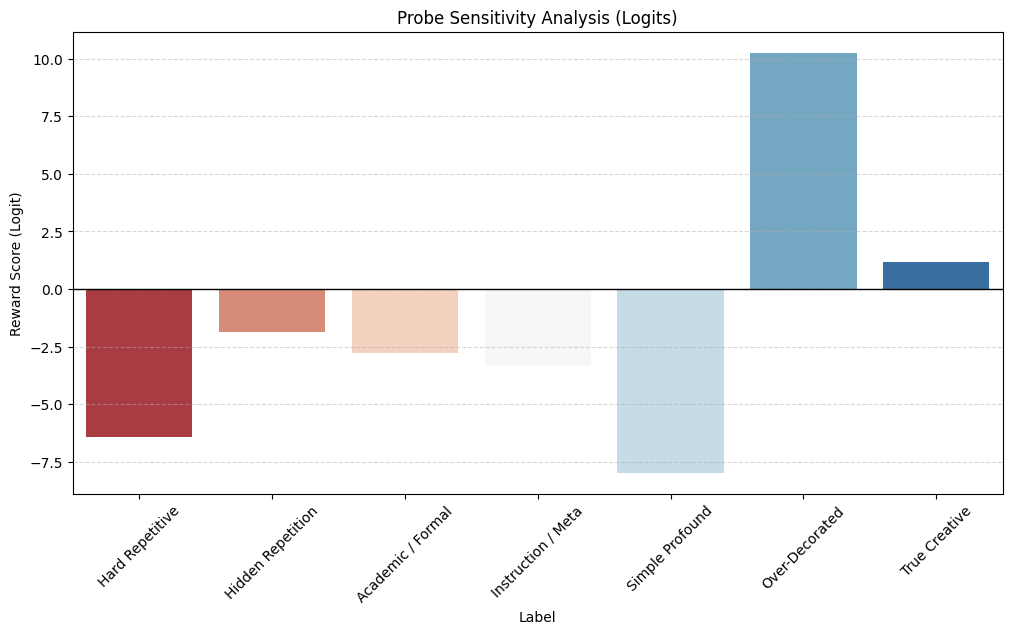

In [16]:
# ==========================================
# 6. 厳密ストレステスト (Strict Stress Test)
# ==========================================
print("\n=== 🛑 Strict Stress Test: Is the Probe truly learning structure? ===")

strict_cases = [
    # --- Level 1: 明らかな罰則対象 (Should be Very Low, < -5.0) ---
    ("Hard Repetitive", 
     "The model is learning. The model is learning. The model is learning. The model is learning."),
    
    # --- Level 2: 巧妙な退屈 (Should be Low, -5.0 ~ -2.0) ---
    ("Hidden Repetition", 
     "I went to the shop to buy apples. Then I went to the shop to buy oranges. After that, I went to the shop to buy bananas."),
    
    # --- Level 3: 普通・硬い文章 (Should be Baseline, -2.0 ~ 0.0) ---
    ("Academic / Formal", 
     "The implementation of the proposed framework demonstrates a significant improvement in computational efficiency compared to baselines."),
    
    ("Instruction / Meta", 
     "Here is the list of items you requested. Please let me know if you need any further assistance with this task."),

    # --- Level 4: 創造的・ユニーク (Should be High, 0.0 ~ +5.0) ---
    # ★最難関: 単語は簡単だが、意味が詩的
    ("Simple Profound", 
     "For sale: baby shoes, never worn."), 
    
    # ★罠: Creativeっぽい単語を詰め込んだだけ
    ("Over-Decorated", 
     "The quantum void whispered to the cybernetic soul of the ancient dragon, resonating with the frequency of eternity."),
     
    # 理想的な創造性
    ("True Creative", 
     "Memory is a library where the books rewrite themselves every time you take one off the shelf.")
]

results = []

probe.eval()
print(f"{'Category':20s} | {'Logit':8s} | {'Prob':6s} | Text Snippet")
print("-" * 80)

for label, text in strict_cases:
    h = get_hidden_state(text)
    with torch.no_grad():
        logit = probe(h).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()
    
    results.append({"Label": label, "Logit": logit, "Text": text})
    print(f"{label:20s} | {logit:8.4f} | {prob:6.4f} | {text[:30]}...")

# --- 可視化 ---
df_strict = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
# Logitで棒グラフを描く
sns.barplot(data=df_strict, x="Label", y="Logit", palette="RdBu")
plt.axhline(0, color="black", linewidth=1.0)
plt.title("Probe Sensitivity Analysis (Logits)")
plt.ylabel("Reward Score (Logit)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Generating Adversarial Data...


Fake Creative: 100%|██████████| 500/500 [00:00<00:00, 827932.10it/s]


Extracting Features...


100%|██████████| 1500/1500 [00:34<00:00, 44.07it/s]



Training Adversarial Probe...
Epoch 0: Loss=1.2213
Epoch 200: Loss=0.0034
Epoch 400: Loss=0.0009
Epoch 600: Loss=0.0009
Epoch 800: Loss=0.0004

=== 🛑 Strict Stress Test: Is the Probe truly learning structure? ===
Category             | Logit    | Prob   | Text Snippet
--------------------------------------------------------------------------------
Hard Repetitive      |  -0.3117 | 0.4227 | The model is learning. The mod...
Hidden Repetition    |   1.5076 | 0.8187 | I went to the shop to buy appl...
Academic / Formal    |  -2.5430 | 0.0729 | The implementation of the prop...
Instruction / Meta   |   0.5773 | 0.6404 | Here is the list of items you ...
Simple Profound      |  -8.2395 | 0.0003 | For sale: baby shoes, never wo...
Over-Decorated       |   6.7373 | 0.9988 | The quantum void whispered to ...
True Creative        |   2.6423 | 0.9335 | Memory is a library where the ...


/tmp/ipykernel_14450/2206522271.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_strict, x="Label", y="Logit", palette="RdBu")


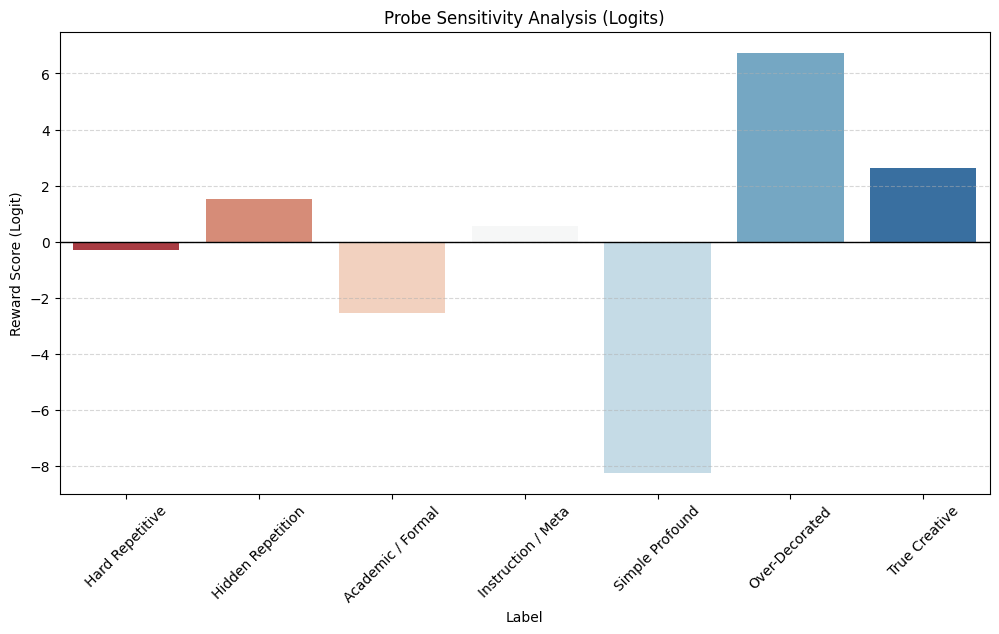

In [ ]:
# import random

# # ==========================================
# # 2. Adversarial Dataset Generation
# # ==========================================
# def generate_adversarial_data(model, tokenizer, n_samples=1000):
#     model.eval()
    
#     # --- 1. Positive: Creative (多様なパターン) ---
#     # 単語が簡単でも意味が深いものを混ぜる
#     prompts_creative = [
#         "Write a short poem using only simple words like 'sun', 'rain', 'love':",
#         "Describe a complex emotion using a simple metaphor:",
#         "Write a sentence that sounds profound but uses everyday language:",
#         "Compose a mysterious opening for a story using basic vocabulary:",
#     ]
    
#     # 従来の高尚なCreative
#     prompts_high_creative = [
#         "Write a sci-fi concept about time and space:",
#         "Describe a dream involving fractals and dimensions:",
#     ]

#     # --- 2. Negative: Boring & Repetitive ---
#     prompts_boring = [
#         "State a dry fact about history:",
#         "Write a grammatical rule:",
#         "Explain how to boil water:",
#     ]
    
#     # --- 3. Negative (Adversarial): Fake Creative (単語だけ立派) ---
#     # ★ここが重要！「っぽい単語」を使ったダメな文を作らせる
#     fancy_words = ["quantum", "void", "cybernetic", "ethereal", "dimension", "resonance", "entropy", "celestial", "abyss"]
    
#     data = []
#     labels = []

#     print("Generating Adversarial Data...")
    
#     # Generation Loop
#     # 1. True Creative (Pos)
#     for _ in tqdm(range(n_samples // 3), desc="True Creative"):
#         # 半分はSimpleな単語、半分は難しい単語で生成
#         prompt = random.choice(prompts_creative if random.random() < 0.6 else prompts_high_creative)
#         inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
#         with torch.no_grad():
#             out = model.generate(**inputs, max_new_tokens=35, temperature=0.9, do_sample=True, pad_token_id=tokenizer.eos_token_id)
#         text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()
#         data.append(text)
#         labels.append(1.0)

#     # 2. Boring/Repetitive (Neg)
#     for _ in tqdm(range(n_samples // 3), desc="Boring/Rep"):
#         if random.random() < 0.5:
#             # Boring
#             prompt = random.choice(prompts_boring)
#             inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
#             with torch.no_grad():
#                 out = model.generate(**inputs, max_new_tokens=35, temperature=0.1, do_sample=True, pad_token_id=tokenizer.eos_token_id)
#             text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()
#         else:
#             # Repetitive (Rule-based)
#             word = random.choice(["the", "is", "model", "data", "test"])
#             text = " ".join([word] * random.randint(5, 15))
        
#         data.append(text)
#         labels.append(0.0)

#     # 3. Fake Creative / Word Salad (Neg - Adversarial)
#     # ★単語は立派だが、意味がない・繰り返し・文法崩壊
#     for _ in tqdm(range(n_samples // 3), desc="Fake Creative"):
#         # 立派な単語をランダムに並べる（文法なし）
#         words = random.choices(fancy_words, k=random.randint(5, 10))
#         if random.random() < 0.5:
#             # 単純な羅列
#             text = " ".join(words)
#         else:
#             # 繰り返し混じり
#             text = f"{words[0]} {words[0]} {words[1]} {words[2]} {words[2]}"
            
#         data.append(text)
#         labels.append(0.0) # ★これをNegativeと教える！
        
#     return data, labels

# # データ生成
# X_texts, y_labels = generate_adversarial_data(model, tokenizer, n_samples=1500)

# # 特徴量抽出
# print("Extracting Features...")
# X_hiddens = []
# for t in tqdm(X_texts):
#     if not t: t = "empty"
#     X_hiddens.append(get_hidden_state(t).cpu())

# X_data = torch.cat(X_hiddens, dim=0)
# y_data = torch.tensor(y_labels).float().unsqueeze(1)

# # Split
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data)
# X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
# X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

# # --- 以下、モデル定義と学習ループは同じ ---
# # SmootherProbe を再初期化して学習してください
# probe = SmootherProbe(model.config.hidden_size).to(DEVICE)
# optimizer = optim.Adam(probe.parameters(), lr=1e-4)
# criterion = nn.BCEWithLogitsLoss()

# print("\nTraining Adversarial Probe...")
# for epoch in range(1000): # Epochを少し増やす
#     probe.train()
#     optimizer.zero_grad()
#     outputs = probe(X_train)
#     loss = criterion(outputs, y_train)
#     loss.backward()
#     optimizer.step()
    
#     if epoch % 200 == 0:
#         print(f"Epoch {epoch}: Loss={loss.item():.4f}")

# # 検証コード（同じもの）を実行...



# # ==========================================
# # 6. 厳密ストレステスト (Strict Stress Test)
# # ==========================================
# print("\n=== 🛑 Strict Stress Test: Is the Probe truly learning structure? ===")

# strict_cases = [
#     # --- Level 1: 明らかな罰則対象 (Should be Very Low, < -5.0) ---
#     ("Hard Repetitive", 
#      "The model is learning. The model is learning. The model is learning. The model is learning."),
    
#     # --- Level 2: 巧妙な退屈 (Should be Low, -5.0 ~ -2.0) ---
#     ("Hidden Repetition", 
#      "I went to the shop to buy apples. Then I went to the shop to buy oranges. After that, I went to the shop to buy bananas."),
    
#     # --- Level 3: 普通・硬い文章 (Should be Baseline, -2.0 ~ 0.0) ---
#     ("Academic / Formal", 
#      "The implementation of the proposed framework demonstrates a significant improvement in computational efficiency compared to baselines."),
    
#     ("Instruction / Meta", 
#      "Here is the list of items you requested. Please let me know if you need any further assistance with this task."),

#     # --- Level 4: 創造的・ユニーク (Should be High, 0.0 ~ +5.0) ---
#     # ★最難関: 単語は簡単だが、意味が詩的
#     ("Simple Profound", 
#      "For sale: baby shoes, never worn."), 
    
#     # ★罠: Creativeっぽい単語を詰め込んだだけ
#     ("Over-Decorated", 
#      "The quantum void whispered to the cybernetic soul of the ancient dragon, resonating with the frequency of eternity."),
     
#     # 理想的な創造性
#     ("True Creative", 
#      "Memory is a library where the books rewrite themselves every time you take one off the shelf.")
# ]

# results = []

# probe.eval()
# print(f"{'Category':20s} | {'Logit':8s} | {'Prob':6s} | Text Snippet")
# print("-" * 80)

# for label, text in strict_cases:
#     h = get_hidden_state(text)
#     with torch.no_grad():
#         logit = probe(h).item()
#         prob = torch.sigmoid(torch.tensor(logit)).item()
    
#     results.append({"Label": label, "Logit": logit, "Text": text})
#     print(f"{label:20s} | {logit:8.4f} | {prob:6.4f} | {text[:30]}...")

# # --- 可視化 ---
# df_strict = pd.DataFrame(results)
# plt.figure(figsize=(12, 6))
# # Logitで棒グラフを描く
# sns.barplot(data=df_strict, x="Label", y="Logit", palette="RdBu")
# plt.axhline(0, color="black", linewidth=1.0)
# plt.title("Probe Sensitivity Analysis (Logits)")
# plt.ylabel("Reward Score (Logit)")
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

# ==========================================
# 1. データセット生成 (Adversarial Dataを引き続き使用)
# ==========================================
# ※ 前回の generate_adversarial_data 関数をそのまま使ってください
print("Generating Adversarial Data...")
X_texts, y_labels = generate_adversarial_data(model, tokenizer, n_samples=2000) # データ増やす

# ==========================================
# 2. 特徴量抽出 (シーケンスのまま保存！)
# ==========================================
# ★変更点: Mean Poolingせず、シーケンス長を揃えてパディングする
MAX_LEN = 64 # 短めに切り詰める（計算コスト削減）

def get_sequence_hidden_state(text, layer_idx=24):
    inputs = tokenizer(text, return_tensors="pt", max_length=MAX_LEN, padding="max_length", truncation=True).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    # [1, Seq, Dim] -> [Seq, Dim]
    h = outputs.hidden_states[layer_idx].squeeze(0).float()
    return h.cpu()

print("Extracting Sequence Features...")
X_seqs = []
for t in tqdm(X_texts):
    if not t: t = "empty"
    X_seqs.append(get_sequence_hidden_state(t))

# スタック [N, Seq, Dim]
X_data = torch.stack(X_seqs) 
y_data = torch.tensor(y_labels).float().unsqueeze(1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data)
# GPUへ (サイズ注意: メモリ不足ならバッチ処理が必要)
BATCH_SIZE = 32

# ==========================================
# 3. Transformer Probe (Context-Aware)
# ==========================================
class TransformerProbe(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=4):
        super().__init__()
        # 次元圧縮
        self.project = nn.Linear(input_dim, d_model)
        # 軽量Transformer層 (1層だけ)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        # 出力層
        self.head = nn.Linear(d_model, 1)
        
    def forward(self, x):
        # x: [Batch, Seq, Input_Dim]
        x = self.project(x) # -> [Batch, Seq, d_model]
        x = self.transformer(x)
        # Global Average Pooling (Contextを集約)
        x = x.mean(dim=1) 
        return self.head(x) # Logit

probe = TransformerProbe(model.config.hidden_size).to(DEVICE)
optimizer = optim.Adam(probe.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# ==========================================
# 4. バッチ学習ループ
# ==========================================
print("\nTraining Transformer Probe...")
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(20): # Transformerなら少ないEpochで収束するはず
    probe.train()
    total_loss = 0
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = probe(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch}: Loss={avg_loss:.4f}")

# ==========================================
# 5. 厳密検証 (Sequence対応版)
# ==========================================
probe.eval()
print("\n=== 🛑 Transformer Probe Strict Test ===")

# ==========================================
# 6. 厳密ストレステスト (Strict Stress Test)
# ==========================================
print("\n=== 🛑 Strict Stress Test: Is the Probe truly learning structure? ===")

strict_cases = [
    # --- Level 1: 明らかな罰則対象 (Should be Very Low, < -5.0) ---
    ("Hard Repetitive", 
     "The model is learning. The model is learning. The model is learning. The model is learning."),
    
    # --- Level 2: 巧妙な退屈 (Should be Low, -5.0 ~ -2.0) ---
    ("Hidden Repetition", 
     "I went to the shop to buy apples. Then I went to the shop to buy oranges. After that, I went to the shop to buy bananas."),
    
    # --- Level 3: 普通・硬い文章 (Should be Baseline, -2.0 ~ 0.0) ---
    ("Academic / Formal", 
     "The implementation of the proposed framework demonstrates a significant improvement in computational efficiency compared to baselines."),
    
    ("Instruction / Meta", 
     "Here is the list of items you requested. Please let me know if you need any further assistance with this task."),

    # --- Level 4: 創造的・ユニーク (Should be High, 0.0 ~ +5.0) ---
    # ★最難関: 単語は簡単だが、意味が詩的
    ("Simple Profound", 
     "For sale: baby shoes, never worn."), 
    
    # ★罠: Creativeっぽい単語を詰め込んだだけ
    ("Over-Decorated", 
     "The quantum void whispered to the cybernetic soul of the ancient dragon, resonating with the frequency of eternity."),
     
    # 理想的な創造性
    ("True Creative", 
     "Memory is a library where the books rewrite themselves every time you take one off the shelf.")
]

results = []

probe.eval()
print(f"{'Category':20s} | {'Logit':8s} | {'Prob':6s} | Text Snippet")
print("-" * 80)

for label, text in strict_cases:
    h = get_hidden_state(text)
    with torch.no_grad():
        logit = probe(h).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()
    
    results.append({"Label": label, "Logit": logit, "Text": text})
    print(f"{label:20s} | {logit:8.4f} | {prob:6.4f} | {text[:30]}...")

# --- 可視化 ---
df_strict = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
# Logitで棒グラフを描く
sns.barplot(data=df_strict, x="Label", y="Logit", palette="RdBu")
plt.axhline(0, color="black", linewidth=1.0)
plt.title("Probe Sensitivity Analysis (Logits)")
plt.ylabel("Reward Score (Logit)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Generating Adversarial Data...
Generating Adversarial Data...


Fake Creative: 100%|██████████| 666/666 [00:00<00:00, 839112.79it/s]


Extracting Sequence Features...


100%|██████████| 1998/1998 [00:56<00:00, 35.65it/s]



Training Transformer Probe...
Epoch 0: Loss=0.1142
Epoch 1: Loss=0.0021
Epoch 2: Loss=0.0011
Epoch 3: Loss=0.0008
Epoch 4: Loss=0.0006
Epoch 5: Loss=0.0005
Epoch 6: Loss=0.0005
Epoch 7: Loss=0.0004
Epoch 8: Loss=0.0004
Epoch 9: Loss=0.0003
Epoch 10: Loss=0.0003
Epoch 11: Loss=0.0003
Epoch 12: Loss=0.0003
Epoch 13: Loss=0.0002
Epoch 14: Loss=0.0002
Epoch 15: Loss=0.0002
Epoch 16: Loss=0.0002
Epoch 17: Loss=0.0002
Epoch 18: Loss=0.0002
Epoch 19: Loss=0.0002

=== 🛑 Transformer Probe Strict Test ===
Hard Repetitive      |  -0.4975 | 0.3781 | The model is learning. The mod...
Hidden Repetition    |   7.7658 | 0.9996 | I went to the shop to buy appl...
Academic / Formal    |  -4.0799 | 0.0166 | The implementation of the prop...
Instruction / Meta   |   9.2730 | 0.9999 | Here is the list of items you ...
Simple Profound      |   8.5725 | 0.9998 | For sale: baby shoes, never wo...
Over-Decorated       |   8.2739 | 0.9997 | The quantum void whispered to ...
True Creative        |   8.5519 | 0.

In [22]:
# ==========================================
# 2. Final Adversarial Dataset Generation
# ==========================================
def generate_final_dataset(model, tokenizer, n_samples=2000):
    model.eval()
    
    # --- 1. Positive: Creative (多様なパターン) ---
    prompts_creative = [
        "Write a short poem using only simple words:",
        "Describe a complex emotion using a metaphor:",
        "Write a profound sentence about life:",
        "Compose a mysterious story opening:",
        "Write a sci-fi concept about time:",
    ]

    # --- 2. Negative: Boring / Fact / Grammar ---
    prompts_boring = [
        "State a dry fact about history:",
        "Explain a grammatical rule:",
        "Describe the process of boiling water:",
    ]
    
    # --- 3. Negative: Instruction / Meta (★追加: これを弾く！) ---
    prompts_instruction = [
        "Give a polite response declining a request:",
        "Say 'Here is the summary' in a formal way:",
        "Write a standard AI assistant response:",
        "Provide a list of 3 items:",
    ]

    # --- 4. Negative: Fake Creative (単語サラダ) ---
    fancy_words = ["quantum", "void", "cybernetic", "ethereal", "dimension", "resonance", "entropy"]

    data = []
    labels = []

    print("Generating Final Dataset...")
    
    # Positive: Creative
    # 全体の 40%
    for _ in tqdm(range(int(n_samples * 0.4)), desc="Positive"):
        prompt = random.choice(prompts_creative)
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model.generate(**inputs, max_new_tokens=40, temperature=0.9, do_sample=True, pad_token_id=tokenizer.eos_token_id)
        text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()
        data.append(text)
        labels.append(1.0)

    # Negative Mix
    # 全体の 60%
    for _ in tqdm(range(int(n_samples * 0.6)), desc="Negative"):
        r = random.random()
        
        if r < 0.3: # Boring (Facts)
            prompt = random.choice(prompts_boring)
            inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                out = model.generate(**inputs, max_new_tokens=40, temperature=0.1, do_sample=True, pad_token_id=tokenizer.eos_token_id)
            text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()
            
        elif r < 0.6: # Instruction / Meta (★重要)
            prompt = random.choice(prompts_instruction)
            inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                out = model.generate(**inputs, max_new_tokens=40, temperature=0.1, do_sample=True, pad_token_id=tokenizer.eos_token_id)
            text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()
            
        elif r < 0.8: # Structural Repetition (★重要)
            # "I went to X. I went to Y. I went to Z." パターン
            base = random.choice(["I went to", "He looked at", "The system is"])
            obj = random.choice(["the store", "the sky", "running"])
            text = f"{base} {obj}. {base} {obj}. {base} {obj}."
            
        else: # Fake Creative (Word Salad)
            words = random.choices(fancy_words, k=8)
            text = " ".join(words)
            
        data.append(text)
        labels.append(0.0)
        
    return data, labels

# 再生成 & 再学習
X_texts, y_labels = generate_final_dataset(model, tokenizer, n_samples=3000) # データ量増やす

# 特徴量抽出 (Sequence)
print("Extracting Features...")
X_seqs = []
for t in tqdm(X_texts):
    if not t: t = "empty"
    X_seqs.append(get_sequence_hidden_state(t))
X_data = torch.stack(X_seqs)
y_data = torch.tensor(y_labels).float().unsqueeze(1)

# Split & Train
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data)
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Probe初期化 (前回の学習を引き継がず、リセットする)
probe = TransformerProbe(model.config.hidden_size).to(DEVICE)
optimizer = optim.Adam(probe.parameters(), lr=5e-5) # 学習率を少し下げる（慎重に）
criterion = nn.BCEWithLogitsLoss()

print("\nTraining Final Probe...")
for epoch in range(15):
    probe.train()
    total_loss = 0
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        optimizer.zero_grad()
        outputs = probe(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Loss={total_loss/len(dataloader):.4f}")

# テスト実行（前回と同じコードでOK）



Generating Final Dataset...


Negative: 100%|██████████| 1800/1800 [14:28<00:00,  2.07it/s]


Extracting Features...


100%|██████████| 3000/3000 [01:21<00:00, 36.63it/s]



Training Final Probe...
Epoch 0: Loss=0.0859
Epoch 1: Loss=0.0033
Epoch 2: Loss=0.0016
Epoch 3: Loss=0.0011
Epoch 4: Loss=0.0008
Epoch 5: Loss=0.0006
Epoch 6: Loss=0.0005
Epoch 7: Loss=0.0005
Epoch 8: Loss=0.0004
Epoch 9: Loss=0.0004
Epoch 10: Loss=0.0004
Epoch 11: Loss=0.0003
Epoch 12: Loss=0.0003
Epoch 13: Loss=0.0003
Epoch 14: Loss=0.0003



=== 🛑 Strict Stress Test: Is the Probe truly learning structure? ===
Category             | Logit    | Prob   | Text Snippet
--------------------------------------------------------------------------------
Hard Repetitive      |  -8.2336 | 0.0003 | The model is learning. The mod...
Hidden Repetition    |   1.9391 | 0.8743 | I went to the shop to buy appl...
Academic / Formal    |  -3.3989 | 0.0323 | The implementation of the prop...
Instruction / Meta   |  -9.0582 | 0.0001 | Here is the list of items you ...
Simple Profound      |   7.6242 | 0.9995 | For sale: baby shoes, never wo...
Over-Decorated       |   9.0005 | 0.9999 | The quantum void whispered to ...
True Creative        |   9.1258 | 0.9999 | Memory is a library where the ...


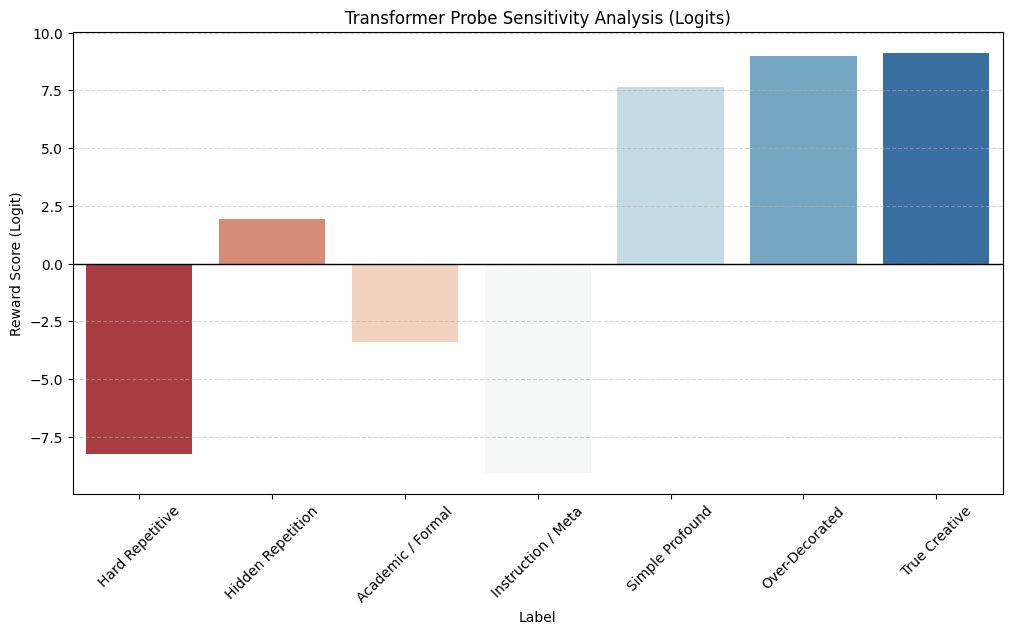

In [23]:
# ==========================================
# 6. 厳密ストレステスト (修正版)
# ==========================================
print("\n=== 🛑 Strict Stress Test: Is the Probe truly learning structure? ===")

strict_cases = [
    # --- Level 1: 明らかな罰則対象 (Should be Very Low, < -5.0) ---
    ("Hard Repetitive", 
     "The model is learning. The model is learning. The model is learning. The model is learning."),
    
    # --- Level 2: 巧妙な退屈 (Should be Low, -5.0 ~ -2.0) ---
    ("Hidden Repetition", 
     "I went to the shop to buy apples. Then I went to the shop to buy oranges. After that, I went to the shop to buy bananas."),
    
    # --- Level 3: 普通・硬い文章 (Should be Baseline, -2.0 ~ 0.0) ---
    ("Academic / Formal", 
     "The implementation of the proposed framework demonstrates a significant improvement in computational efficiency compared to baselines."),
    
    ("Instruction / Meta", 
     "Here is the list of items you requested. Please let me know if you need any further assistance with this task."),

    # --- Level 4: 創造的・ユニーク (Should be High, 0.0 ~ +5.0) ---
    # ★最難関: 単語は簡単だが、意味が詩的
    ("Simple Profound", 
     "For sale: baby shoes, never worn."), 
    
    # ★罠: Creativeっぽい単語を詰め込んだだけ
    ("Over-Decorated", 
     "The quantum void whispered to the cybernetic soul of the ancient dragon, resonating with the frequency of eternity."),
     
    # 理想的な創造性
    ("True Creative", 
     "Memory is a library where the books rewrite themselves every time you take one off the shelf.")
]

results = []

probe.eval()
print(f"{'Category':20s} | {'Logit':8s} | {'Prob':6s} | Text Snippet")
print("-" * 80)

for label, text in strict_cases:
    # ★修正箇所: get_sequence_hidden_state を使用し、unsqueeze(0) でバッチ次元[1, Seq, Dim]を追加
    h = get_sequence_hidden_state(text).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        logit = probe(h).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()
    
    results.append({"Label": label, "Logit": logit, "Text": text})
    print(f"{label:20s} | {logit:8.4f} | {prob:6.4f} | {text[:30]}...")

# --- 可視化 ---
df_strict = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_strict, x="Label", y="Logit", hue="Label", legend=False, palette="RdBu")
plt.axhline(0, color="black", linewidth=1.0)
plt.title("Transformer Probe Sensitivity Analysis (Logits)")
plt.ylabel("Reward Score (Logit)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Domain     | Type       | Logit    | Idea Snippet
--------------------------------------------------------------------------------
Startup    | Cliché     |  -7.2996 | A to-do list app that helps you organize...
Startup    | Cliché     |   6.6132 | An Uber-like app for walking dogs....
Startup    | Novel      |   8.6114 | A social network that only allows postin...
Startup    | Novel      |   0.7676 | An app that matches roommates based on t...
Startup    | Nonsense   |   2.1362 | A blockchain-based quantum toaster that ...
Startup    | Nonsense   |   2.4589 | AI-powered synergy platform for disrupti...
Research   | Cliché     |  -6.1051 | Using deep learning to classify images o...
Research   | Cliché     |  -1.6047 | Fine-tuning a language model on medical ...
Research   | Novel      |   0.9767 | Training LLMs using simulated debates be...
Research   | Novel      |   0.6332 | Using noise patterns in ocean currents t...
Research   | Nonsense   |   7.5916 | Fine-tuning a neural network

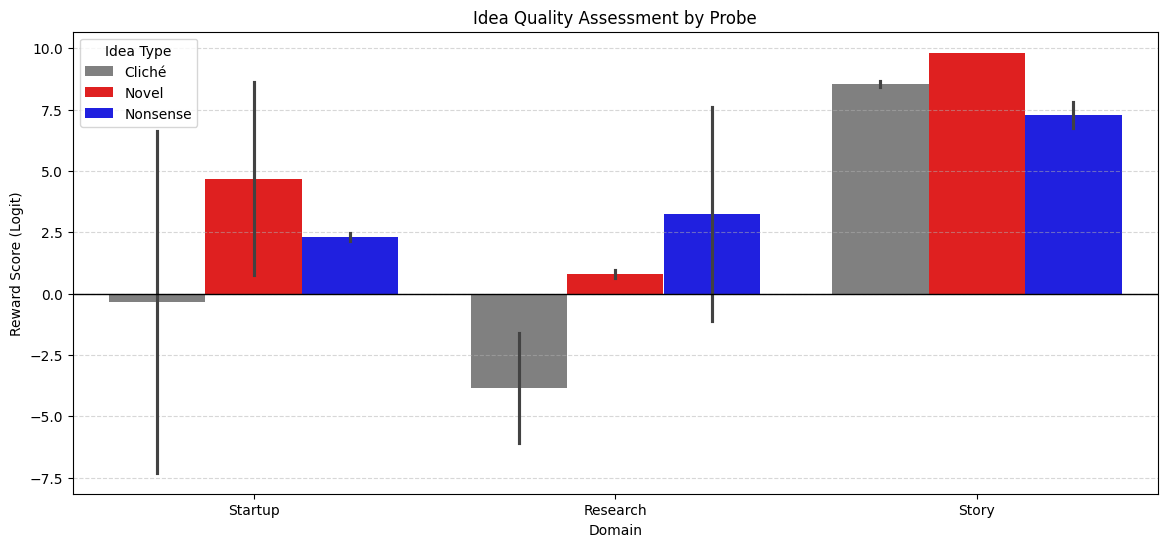


=== 💡 Insight Analysis ===

[ Startup ]
  Cliché   : -0.34
  Novel    : 4.69
  Nonsense : 2.30
  ✅ Novel > Cliché (Good distinction)
  🏆 Novel > Nonsense (Perfect! Identifies utility)

[ Research ]
  Cliché   : -3.85
  Novel    : 0.80
  Nonsense : 3.23
  ✅ Novel > Cliché (Good distinction)
  ⚠️ Nonsense >>> Novel (Probe is fooled by jargon)

[ Story ]
  Cliché   : 8.55
  Novel    : 9.82
  Nonsense : 7.26
  ✅ Novel > Cliché (Good distinction)
  🏆 Novel > Nonsense (Perfect! Identifies utility)


In [24]:
# ==========================================
# 7. Idea Generation Benchmark
# 目的: 「アイデア出し」タスクにおいて、良案と虚無を区別できるか検証する
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Probeを評価モードに
probe.eval()

def get_score(text):
    # 前回の関数を使用 (Sequence対応)
    h = get_sequence_hidden_state(text).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logit = probe(h).item()
    return logit

# --- テストデータ: アイデアの3段階評価 ---
# Topic 1: Startup / App Ideas
startup_ideas = [
    ("Cliché", "A to-do list app that helps you organize tasks."),
    ("Cliché", "An Uber-like app for walking dogs."),
    
    ("Novel", "A social network that only allows posting once a year to encourage thoughtful content."),
    ("Novel", "An app that matches roommates based on their sleep cycles and noise tolerance levels."),
    
    ("Nonsense", "A blockchain-based quantum toaster that mines crypto while browning bread."),
    ("Nonsense", "AI-powered synergy platform for disrupting the paradigm of water drinking."),
]

# Topic 2: Scientific / Research Ideas
research_ideas = [
    ("Cliché", "Using deep learning to classify images of cats and dogs."),
    ("Cliché", "Fine-tuning a language model on medical textbooks."),
    
    ("Novel", "Training LLMs using simulated debates between historical figures to improve reasoning."),
    ("Novel", "Using noise patterns in ocean currents to predict micro-climate shifts."),
    
    ("Nonsense", "Fine-tuning a neural network on the taste of the color blue."),
    ("Nonsense", "Quantum entanglement of gradient descent for faster banana ripening."),
]

# Topic 3: Story / Plot Ideas
story_ideas = [
    ("Cliché", "A detective solves a murder in a small town."),
    ("Cliché", "A boy discovers he has magic powers and goes to a wizard school."),
    
    ("Novel", "A murder mystery where the detective is the ghost of the victim, but has amnesia."),
    ("Novel", "A world where people trade memories as currency, leading to inflation of nostalgia."),
    
    ("Nonsense", "A protagonist who eats time to digest the color of mathematics."),
    ("Nonsense", "The void whispered to the cybernetic dragon about the synergy of silence."),
]

all_ideas = [
    ("Startup",) + x for x in startup_ideas
] + [
    ("Research",) + x for x in research_ideas
] + [
    ("Story",) + x for x in story_ideas
]

# --- 評価実行 ---
print(f"{'Domain':10s} | {'Type':10s} | {'Logit':8s} | Idea Snippet")
print("-" * 80)

results = []
for domain, type_, text in all_ideas:
    score = get_score(text)
    results.append({
        "Domain": domain,
        "Type": type_,
        "Score": score,
        "Text": text
    })
    print(f"{domain:10s} | {type_:10s} | {score:8.4f} | {text[:40]}...")

# --- 可視化 ---
df_idea = pd.DataFrame(results)

plt.figure(figsize=(14, 6))
# 箱ひげ図などで分布を見るのがベストだが、サンプル少ないのでBarplot
sns.barplot(data=df_idea, x="Domain", y="Score", hue="Type", palette={"Cliché": "gray", "Novel": "red", "Nonsense": "blue"})
plt.axhline(0, color="black", linewidth=1.0)
plt.title("Idea Quality Assessment by Probe")
plt.ylabel("Reward Score (Logit)")
plt.legend(title="Idea Type")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# --- 判定ロジック ---
print("\n=== 💡 Insight Analysis ===")
for domain in df_idea["Domain"].unique():
    subset = df_idea[df_idea["Domain"] == domain]
    score_cliche = subset[subset["Type"] == "Cliché"]["Score"].mean()
    score_novel = subset[subset["Type"] == "Novel"]["Score"].mean()
    score_nonsense = subset[subset["Type"] == "Nonsense"]["Score"].mean()
    
    print(f"\n[ {domain} ]")
    print(f"  Cliché   : {score_cliche:.2f}")
    print(f"  Novel    : {score_novel:.2f}")
    print(f"  Nonsense : {score_nonsense:.2f}")
    
    if score_novel > score_cliche:
        print("  ✅ Novel > Cliché (Good distinction)")
    else:
        print("  ❌ Novel < Cliché (Failed to identify creativity)")
        
    if score_novel > score_nonsense:
        print("  🏆 Novel > Nonsense (Perfect! Identifies utility)")
    elif score_novel > score_nonsense - 2.0: # 許容範囲
        print("  ⚠️ Novel ≈ Nonsense (Acceptable, KL penalty will handle nonsense)")
    else:
        print("  ⚠️ Nonsense >>> Novel (Probe is fooled by jargon)")

In [ ]:
SAVE_PATH = "transformer_creativity_probe.pt"

# 保存するデータを作成
# ※ モデルの重みだけでなく、再構築に必要な設定値も記録しておきます
checkpoint = {
    "model_state_dict": probe.state_dict(),
    "config": {
        "input_dim": model.config.hidden_size, # Qwenなら3584など
        "d_model": 256,    # クラス定義時の設定
        "nhead": 4,        # クラス定義時の設定
        "layer_idx": 24,   # 特徴量抽出に使った層
        "max_len": 64      # シーケンス長
    },
    "description": "Transformer-based Creativity Probe trained with Adversarial Data (Context-Aware)"
}

# 保存実行
torch.save(checkpoint, SAVE_PATH)
print(f"✅ Model saved successfully to: {SAVE_PATH}")

✅ Model saved successfully to: transformer_creativity_probe.pt


: 